In [1]:
import os
from langchain_openai import ChatOpenAI
from langchain_core.tools import tool
from langchain_core.messages import HumanMessage
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.utils.function_calling import convert_to_openai_function

# Set up your OpenAI API key (replace with your key or use environment variable)


In [3]:
import json

@tool
def execute_python_code(code: str) -> str:
    """
    Execute Python code safely using eval.
    
    Args:
        code: Python code to execute (simple expressions only)
    
    Returns:
        String containing the result of the code execution
    """
    try:
        import sys
        from io import StringIO
        
        # Capture stdout
        old_stdout = sys.stdout
        sys.stdout = captured_output = StringIO()
        
        # Create a safe execution environment
        safe_globals = {"__builtins__": __builtins__}
        safe_locals = {}
        
        # Execute the code
        exec(code, safe_globals, safe_locals)
        
        # Get the output
        output = captured_output.getvalue()
        
        # Restore stdout
        sys.stdout = old_stdout
        
        if output.strip():
            return f"The result of the code execution is:\n\n```\n{output.strip()}\n```"
        else:
            # If no output, try to get the last expression value
            try:
                result = eval(code, safe_globals, safe_locals)
                return f"The result of the code execution is:\n\n```\n{result}\n```"
            except:
                return "Code executed successfully (no output)"
                
    except Exception as e:
        return f"Error executing code: {str(e)}"

# # Print the schema of this tool
print(json.dumps(execute_python_code.args_schema.model_json_schema()))

{"description": "Execute Python code safely using eval.\n\nArgs:\n    code: Python code to execute (simple expressions only)\n\nReturns:\n    String containing the result of the code execution", "properties": {"code": {"title": "Code", "type": "string"}}, "required": ["code"], "title": "execute_python_code", "type": "object"}


In [4]:
convert_to_openai_function(execute_python_code.args_schema.model_json_schema())

{'name': 'execute_python_code',
 'description': 'Execute Python code safely using eval.\n\nArgs:\n    code: Python code to execute (simple expressions only)\n\nReturns:\n    String containing the result of the code execution',
 'parameters': {'properties': {'code': {'title': 'Code', 'type': 'string'}},
  'required': ['code'],
  'type': 'object'}}

In [5]:
import json

from langchain_anthropic import ChatAnthropic
from langchain_groq import ChatGroq
from langchain_ollama import ChatOllama

reasoning_llm = ChatGroq(
    model="qwen/qwen3-32b",
    max_tokens=None,
    reasoning_format="parsed",
    # reasoning_effort="none",
    timeout=None,
    max_retries=2,
)

reasoning_llm = ChatAnthropic(
    model="claude-sonnet-4-0",
    max_tokens=5000,
    model_kwargs={"thinking": {"type": "enabled", "budget_tokens": 2000}},
)

# reasoning_llm = ChatOllama(
#     model="qwen3:0.6b",
#     max_tokens=None,
# )


In [6]:
# response = reasoning_llm.invoke("What is the cube root of 27?")
# print(json.dumps(response.content, indent=2))

# response

In [7]:
model_name = reasoning_llm.model if hasattr(reasoning_llm, "model") else reasoning_llm.model_name
print(f"Using model: {model_name}")

Using model: claude-sonnet-4-0


In [6]:
# Create the React agent
simple_reasoning_agent = create_react_agent(
    reasoning_llm,
    tools=[execute_python_code],
    checkpointer=MemorySaver()
)

print(f"🚀 Testing Simple Reasoning Agent with {model_name}")

# Test it
try:
    result = simple_reasoning_agent.invoke(
        {"messages": [HumanMessage(content="Calculate 25 * 37 + 100 using Python code and once you do, write another code snippet that multiples it by 1,454,233")]},
        config={"configurable": {"thread_id": "simple-test"}}
    )
    print("✅ Simple agent completed successfully!")
    for msg in result["messages"]:
        print("=" * 60)
        print(f"{type(msg)}")
        reasoning = None
        if hasattr(msg, "additional_kwargs") and "reasoning_content" in getattr(msg, "additional_kwargs", {}):
            reasoning = msg.additional_kwargs["reasoning_content"]
        elif hasattr(msg, "reasoning") and getattr(msg, "reasoning"):
            reasoning = getattr(msg, "reasoning")
        if reasoning:
            print(f"  [REASONING]: {reasoning}")

        # Print Anthropic-style content if present
        if hasattr(msg, "content") and isinstance(msg.content, list):
            for part in msg.content:
                if isinstance(part, dict):
                    part_type = part.get("type")
                    if part_type == "thinking":
                        print(f"  [THINKING]: {part.get('thinking')}")
                    elif part_type == "text":
                        print(f"  [TEXT]: {part.get('text')}")
                    elif part_type == "tool_use":
                        print(f"  [TOOL USE]: {part}")
                    else:
                        print(f"  [PART-{part_type}]: {part}")
                else:
                    print(f"  [PART]: {part}")
        elif hasattr(msg, "content") and isinstance(msg.content, str):
            print(f"  [TEXT]: {msg.content}")

        # Print Groq-style tool calls if present
        # (tool_calls is a list of dicts, each with keys: name, args, id, type)
        if hasattr(msg, "tool_calls") and msg.tool_calls:
            for tool_call in msg.tool_calls:
                print(f"  [TOOL CALL]:")
                print(f"    id: {tool_call.get('id')}")
                print(f"    name: {tool_call.get('name')}")
                print(f"    type: {tool_call.get('type')}")
                print(f"    args: {tool_call.get('args')}")
    print("=" * 60)

except Exception as e:
    print(f"❌ Error with simple agent: {e}")
    print(f"Error type: {type(e).__name__}")


NameError: name 'execute_python_code' is not defined

In [15]:
# Set up ChatOllama with qwen3:0.6b and create a React agent with Google search
import requests
from bs4 import BeautifulSoup
import urllib.parse
from langchain_core.tools import tool
from langchain_ollama import ChatOllama
from langgraph.prebuilt import create_react_agent
from langgraph.checkpoint.memory import MemorySaver
from langchain_core.messages import HumanMessage

@tool
def web_search(query: str) -> str:
    """
    Search the web for information about a query.
    
    Args:
        query: The search query to look up on the web
    
    Returns:
        String containing search results and snippets
    """
    try:
        # Use DuckDuckGo as an alternative since it doesn't require API keys
        search_url = f"https://duckduckgo.com/html/?q={urllib.parse.quote(query)}"
        headers = {
            'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
        }
        
        response = requests.get(search_url, headers=headers, timeout=10)
        soup = BeautifulSoup(response.content, 'html.parser')
        
        # Extract search results
        results = []
        result_items = soup.find_all('div', class_='result')[:5]  # Get top 5 results
        
        for item in result_items:
            title_elem = item.find('h2')
            snippet_elem = item.find('a', class_='result__snippet')
            url_elem = item.find('a', class_='result__url')
            
            if title_elem and snippet_elem:
                title = title_elem.get_text(strip=True)
                snippet = snippet_elem.get_text(strip=True)
                url = url_elem.get('href') if url_elem else 'No URL'
                
                results.append(f"**{title}**\n{snippet}\nURL: {url}\n")
        
        if results:
            return f"Search results for '{query}':\n\n" + "\n".join(results)
        else:
            return f"No results found for '{query}'. Try rephrasing your search query."
            
    except Exception as e:
        return f"Error performing search: {str(e)}. You might need to install required packages: pip install requests beautifulsoup4"

# Set up the ChatOllama model with qwen3:0.6b
reasoning_llm = ChatOllama(
    model="qwen3:0.6b",
    max_tokens=None,
)

# Create a React agent that can search Google
web_search_agent = create_react_agent(
    reasoning_llm,
    tools=[web_search],
    checkpointer=MemorySaver()
)

print(f"🔍 Google Search Agent with qwen3:0.6b is ready!")
print("You can now ask me to search for anything on the web.")

# Test the agent
try:
    result = web_search_agent.invoke(
        {"messages": [HumanMessage(content="Who is Sinan Ozdemir in AI?")]},
        config={"configurable": {"thread_id": "web-search-test"}}
    )
    
    print("\n" + "="*60)
    print("🎉 Google Search Agent Test Results:")
    print("="*60)
    
    for msg in result["messages"]:
        if hasattr(msg, 'content') and isinstance(msg.content, str) and msg.content.strip():
            msg_type = type(msg).__name__
            print(f"\n[{msg_type}]:")
            print(msg.content)
            
        for ai_responses in result['messages'][1:]:
            # Print all AI responses after the first message (which is usually the HumanMessage)
            if hasattr(ai_responses, 'content') and isinstance(ai_responses.content, str) and ai_responses.content.strip():
                msg_type = type(ai_responses).__name__
                print(f"\n[{msg_type}]:")
                print(ai_responses.content)


except Exception as e:
    print(f"❌ Error with Google search agent: {e}")
    print("Make sure Ollama is running and the qwen3:0.6b model is installed:")
    print("  ollama pull qwen3:0.6b")


🔍 Google Search Agent with qwen3:0.6b is ready!
You can now ask me to search for anything on the web.

🎉 Google Search Agent Test Results:

[HumanMessage]:
Who is Sinan Ozdemir in AI?

[AIMessage]:
<think>
Okay, the user is asking, "Who is Sinan Ozdemir in AI?" Let me break this down. First, I need to figure out what Sinan Ozdemir is in the context of AI. The user is probably referring to a person in the AI field, maybe a researcher, developer, or someone involved in AI technologies.

I should start by confirming the user's intent. They might be looking for information about Sinan Ozdemir's role or contributions to AI. Since the query is in AI, I need to check if there's any specific information available. The provided tool is a web search function, so I should use that to find relevant information.

I need to make sure to search for Sinan Ozdemir's role in AI. Maybe look into his academic background, research areas, or contributions. The function call should be structured with a query

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import time
import psutil
import os
import tempfile

def cosine_similarity(a, b):
    a_norm = a / np.linalg.norm(a, axis=1, keepdims=True)
    b_norm = b / np.linalg.norm(b, axis=1, keepdims=True)
    return np.dot(a_norm, b_norm.T)

def dot_product(a, b):
    return np.dot(a, b.T)

def get_memory_usage_mb():
    process = psutil.Process(os.getpid())
    mem_bytes = process.memory_info().rss
    return mem_bytes / (1024 * 1024)

def get_file_size_mb(filepath):
    return os.path.getsize(filepath) / (1024 * 1024)

from statistics import median

# We'll print and graph at the same time, collecting results as we go.
cosine_times = []
dot_times = []
cosine_mem_deltas = []
dot_mem_deltas = []
cosine_disk_usages = []
dot_disk_usages = []

num_vectors = 1_000_000
num_queries = 10
embed_sizes = [64, 128, 256, 512, 1024]
num_runs = 5  # Number of runs for median

print("\n===== Embedding Similarity Speed, Memory & Disk Test (Print + Graph, Median of 5 runs) =====")
print(f"Testing with {num_vectors} database vectors and {num_queries} query vectors.\n")

sizes = embed_sizes  # for plotting

for size in sizes:
    print(f"\n--- Embedding size: {size} ---")
    # Generate random database and query embeddings
    db_vectors = np.random.randn(num_vectors, size).astype(np.float32)
    query_vectors = np.random.randn(num_queries, size).astype(np.float32)
    
    # Save db_vectors to disk to simulate vector store storage
    with tempfile.NamedTemporaryFile(delete=False, suffix=".npy") as db_file:
        np.save(db_file, db_vectors)
        db_file_path = db_file.name
    db_disk_usage = get_file_size_mb(db_file_path)
    
    # Save query_vectors to disk to simulate vector store storage (optional, for completeness)
    with tempfile.NamedTemporaryFile(delete=False, suffix=".npy") as query_file:
        np.save(query_file, query_vectors)
        query_file_path = query_file.name
    query_disk_usage = get_file_size_mb(query_file_path)
    
    # For each method, run 5 times and take the median
    cos_times = []
    cos_mem_deltas = []
    dot_times_ = []
    dot_mem_deltas_ = []
    for run in range(num_runs):
        # Memory usage before similarity
        mem_before = get_memory_usage_mb()
        
        # Cosine similarity
        t0 = time.time()
        cos_sim = cosine_similarity(query_vectors, db_vectors)
        t1 = time.time()
        mem_after_cos = get_memory_usage_mb()
        cos_time = t1 - t0
        cos_mem_delta = mem_after_cos - mem_before
        cos_times.append(cos_time)
        cos_mem_deltas.append(cos_mem_delta)
        
        # Dot product
        t2 = time.time()
        dot_sim = dot_product(query_vectors, db_vectors)
        t3 = time.time()
        mem_after_dot = get_memory_usage_mb()
        dot_time = t3 - t2
        dot_mem_delta = mem_after_dot - mem_after_cos
        dot_times_.append(dot_time)
        dot_mem_deltas_.append(dot_mem_delta)
    
    # Take the median of the 5 runs
    cos_time_med = median(cos_times)
    cos_mem_delta_med = median(cos_mem_deltas)
    dot_time_med = median(dot_times_)
    dot_mem_delta_med = median(dot_mem_deltas_)
    
    cosine_times.append(cos_time_med)
    cosine_mem_deltas.append(cos_mem_delta_med)
    cosine_disk_usages.append(db_disk_usage)
    dot_times.append(dot_time_med)
    dot_mem_deltas.append(dot_mem_delta_med)
    dot_disk_usages.append(db_disk_usage)
    
    print(f"Cosine similarity (median of {num_runs}): {cos_time_med:.4f} sec, ΔMem: {cos_mem_delta_med:.2f} MB, DB Disk: {db_disk_usage:.2f} MB, Output shape: {cos_sim.shape}")
    print(f"Dot product      (median of {num_runs}): {dot_time_med:.4f} sec, ΔMem: {dot_mem_delta_med:.2f} MB, DB Disk: {db_disk_usage:.2f} MB, Output shape: {dot_sim.shape}")
    
    # Clean up temp files
    os.remove(db_file_path)
    os.remove(query_file_path)

print("\n===== Test Complete =====")


===== Embedding Similarity Speed, Memory & Disk Test (Print + Graph, Median of 5 runs) =====
Testing with 1000000 database vectors and 10 query vectors.


--- Embedding size: 64 ---
Cosine similarity (median of 5): 0.2134 sec, ΔMem: 1.97 MB, DB Disk: 244.14 MB, Output shape: (10, 1000000)
Dot product      (median of 5): 0.0334 sec, ΔMem: 0.03 MB, DB Disk: 244.14 MB, Output shape: (10, 1000000)

--- Embedding size: 128 ---
Cosine similarity (median of 5): 0.3352 sec, ΔMem: 7.83 MB, DB Disk: 488.28 MB, Output shape: (10, 1000000)
Dot product      (median of 5): 0.0402 sec, ΔMem: 0.08 MB, DB Disk: 488.28 MB, Output shape: (10, 1000000)

--- Embedding size: 256 ---
Cosine similarity (median of 5): 0.4869 sec, ΔMem: 7.70 MB, DB Disk: 976.56 MB, Output shape: (10, 1000000)
Dot product      (median of 5): 0.0708 sec, ΔMem: 0.00 MB, DB Disk: 976.56 MB, Output shape: (10, 1000000)

--- Embedding size: 512 ---
Cosine similarity (median of 5): 1.3028 sec, ΔMem: 7.72 MB, DB Disk: 1953.13 MB, Outp

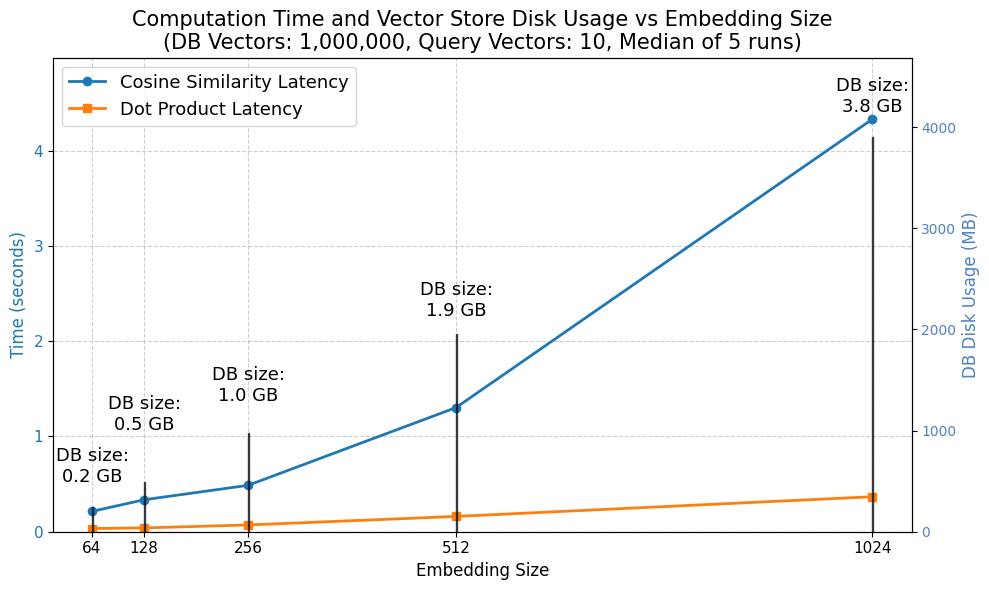

In [23]:
# Combined Plot: Computation Time and Disk Usage

import numpy as np

fig, ax1 = plt.subplots(figsize=(10, 6))

color1 = "#1f77b4"
color2 = "#ff7f0e"

# Plot computation time (left y-axis)
lns1 = ax1.plot(sizes, cosine_times, marker='o', label='Cosine Similarity Latency', color=color1, linewidth=2)
lns2 = ax1.plot(sizes, dot_times, marker='s', label='Dot Product Latency', color=color2, linewidth=2)
ax1.set_xlabel('Embedding Size', fontsize=12)
ax1.set_ylabel('Time (seconds)', fontsize=12, color=color1)
ax1.tick_params(axis='y', labelcolor=color1)
ax1.set_xticks(sizes)
ax1.grid(True, which='both', linestyle='--', alpha=0.6)
ax1.tick_params(axis='both', which='major', labelsize=11)

# Set y-limits for computation time axis manually
ax1.set_ylim([0, max(max(cosine_times), max(dot_times)) * 1.15])


# Create a second y-axis for disk usage
ax2 = ax1.twinx()
# Make bars thicker by increasing their width
thicker_bar_width = 0.6  # Increased from 0.3 to 0.6 for thicker bars
bars = ax2.bar(
    [s + thicker_bar_width/2 for s in sizes], 
    cosine_disk_usages, 
    width=thicker_bar_width, 
    color="#4F81BD", 
    edgecolor='black', 
    alpha=0.7, 
    label=''
)
ax2.set_ylabel('DB Disk Usage (MB)', fontsize=12, color="#4F81BD")
ax2.tick_params(axis='y', labelcolor="#4F81BD")

# Set y-limits for disk usage axis manually
ax2.set_ylim([0, max(cosine_disk_usages) * 1.2])

# Annotate bars with values - spread out vertically to avoid bunching
for idx, bar in enumerate(bars):
    height = bar.get_height()
    if height > 0:
        # Vary the vertical offset more dramatically to spread out labels
        if idx == 0:
            y_offset = 15
        elif idx == 1:
            y_offset = 35
        elif idx == 2:
            y_offset = 20
        elif idx == 3:
            y_offset = 10
        else:
            y_offset = 15
            
        ax2.annotate(f'DB size:\n{height / 1024:,.1f} GB',
                     xy=(bar.get_x() + bar.get_width() / 2, height),
                     xytext=(0, y_offset),
                     textcoords="offset points",
                     ha='center', va='bottom', fontsize=13, color='black')

# Combine legends from both axes
lns = lns1 + lns2
labels = [l.get_label() for l in lns1 + lns2]
ax1.legend(lns, labels, fontsize=13, loc='upper left')

# Add assumptions to the graph title
plt.title(
    f'Computation Time and Vector Store Disk Usage vs Embedding Size\n'
    f'(DB Vectors: {num_vectors:,}, Query Vectors: {num_queries}, Median of {num_runs} runs)',
    fontsize=15
)
plt.tight_layout()
plt.savefig("embedding_similarity_time_disk_combined.png", dpi=300)
plt.show()
